In [1]:
import os
import glob
import hydromt
import pandas as pd
from hydromt import DataCatalog
import xarray as xr
import numpy as np
from os.path import join
import geopandas as gpd
from hydromt_sfincs import SfincsModel, utils
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors, patheffects
from string import ascii_lowercase as abcd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec

In [2]:
cat_dir = r'Z:\Data-Expansion\users\lelise\data'
yml_base_CONUS = os.path.join(cat_dir, 'data_catalog_BASE_CONUS.yml')
yml_base_Carolinas = os.path.join(cat_dir, 'data_catalog_BASE_Carolinas.yml')
yml_sfincs_Carolinas = os.path.join(cat_dir, 'data_catalog_SFINCS_Carolinas.yml')

os.chdir(r'Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter1_FlorenceValidation\sfincs_models\mod_v4_flor')
model_root = 'ENC_200m_sbg5m_avgN_adv1_eff75'
mod = SfincsModel(model_root, mode='r', data_libs=[yml_base_CONUS, yml_base_Carolinas, yml_sfincs_Carolinas])
cat = mod.data_catalog

In [3]:
# Load Floodmaps
res=200
da = xr.open_dataset(os.path.join(os.getcwd(), 'floodmaps', f'{res}m', 'floodmaps.nc'))

In [4]:
# Create working directory
out_dir = os.path.join(os.getcwd(), 'process_attribution', f'{res}m')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
os.chdir(out_dir)

In [5]:
# Load files created using "compound_flooding_analysis.py" script
da_c = xr.open_dataarray('flor_peakWL_attributed_all.nc')
da_diff = xr.open_dataset('flor_peakWL_compound_minus_maxIndiv_all.nc')
da_c_drivers = xr.open_dataarray('flor_peakWL_attributed_toDrivers_all.nc')

In [9]:
'''Load contextual layers for plotting'''
font = {'family': 'Arial', 'size': 10}
mpl.rc('font', **font)

l_gdf = cat.get_geodataframe(
    r'Z:\Data-Expansion\users\lelise\data\geospatial\hydrography\nhd\NHD_H_North_Carolina_State_Shape\Shape\WBDHU6.shp')
l_gdf = l_gdf[l_gdf['Name'].isin(['Pamlico', 'Neuse', 'Onslow Bay', 'Cape Fear', 'Lower Pee Dee'])]
l_gdf.to_crs(epsg=32617, inplace=True)
basins = l_gdf

l_gdf = cat.get_geodataframe(
    r'Z:\Data-Expansion\users\lelise\data\geospatial\infrastructure\tl_2019_us_primaryroads\tl_2019_us_primaryroads.shp')
l_gdf = l_gdf[l_gdf['FULLNAME'].isin(['I- 95'])]
l_gdf.to_crs(epsg=32617, inplace=True)
roads = l_gdf.clip(basins.total_bounds)

l_gdf = cat.get_geodataframe(r'Z:\Data-Expansion\users\lelise\data\geospatial\infrastructure\enc_major_cities.shp')
l_gdf = l_gdf[l_gdf['Name'].isin(['Myrtle Beach', 'Wilmington', 'Raleigh'])]
l_gdf.set_index('Name', inplace=True)
l_gdf.to_crs(epsg=32617, inplace=True)
cities = l_gdf.clip(basins)

l_gdf = cat.get_geodataframe(r'Z:\Data-Expansion\users\lelise\data\geospatial\infrastructure\enc_major_reservoirs.shp')
l_gdf.set_index('Name', inplace=True)
l_gdf.to_crs(epsg=32617, inplace=True)
reservoirs = l_gdf.clip(basins)

tc_tracks = cat.get_geodataframe(r'Z:\Data-Expansion\users\lelise\data\geospatial\hurricane_tracks\IBTrACS.NA.list.v04r00.lines\IBTrACS.NA.list.v04r00.lines.shp')
tc_tracks.to_crs(epsg=32617, inplace=True)
tc_tracks = tc_tracks.clip(basins.total_bounds)

In [10]:
print(os.getcwd())

Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter1_FlorenceValidation\sfincs_models\mod_v4_flor\process_attribution\200m


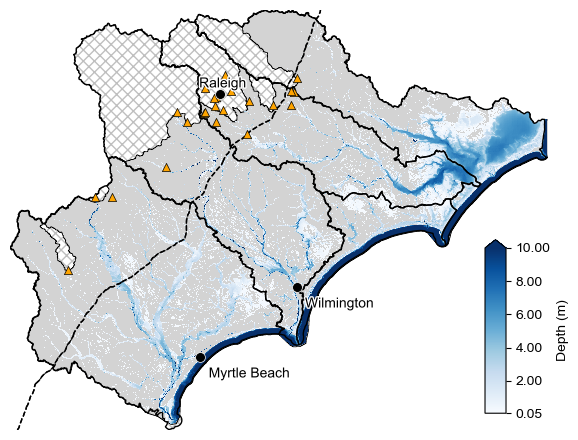

In [22]:
'''Plot 1: Peak Flood Depth - Compound '''
da_p = da.sel(run=model_root)['hmax']

fig, ax = plt.subplots(tight_layout=True, figsize=(6, 4.5))

# Plot difference in water level raster
ckwargs = dict(cmap='Blues', vmin=0.05, vmax=10)
cs = da_p.plot(ax=ax, add_colorbar=False, **ckwargs, zorder=2)

# Plot background/geography layers
basins.plot(ax=ax, color='white', edgecolor='black', linewidth=0.1, linestyle='-', zorder=0, alpha=0.25,
            hatch='xxx')
mod.region.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5, zorder=1, alpha=1)
basins.plot(ax=ax, color='none', edgecolor='black', linewidth=1, linestyle='-', zorder=3, alpha=1)
roads.plot(ax=ax, color='black', edgecolor='none', linewidth=1, linestyle='--', zorder=3, alpha=1)
reservoirs.plot(ax=ax, marker='^', markersize=35, color="orange", edgecolor='black', linewidth=0.5, label='none', zorder=4)
cities.plot(ax=ax, marker='o', markersize=50, color="black", label='none', zorder=4, edgecolor='white',
            linewidth=0.5)

for label, grow in cities.iterrows():
    x, y = grow.geometry.x, grow.geometry.y
    if label == 'Raleigh':
        ann_kwargs = dict(
            xytext=(-15, 5),
            textcoords="offset points",
            zorder=4,
            path_effects=[
                patheffects.Stroke(linewidth=2, foreground="w"),
                patheffects.Normal(), ], )
    else:
        ann_kwargs = dict(
            xytext=(6, -15),
            textcoords="offset points",
            zorder=4,
            path_effects=[
                patheffects.Stroke(linewidth=2, foreground="w"),
                patheffects.Normal(), ], )
    ax.annotate(f'{label}', xy=(x, y), fontsize=10, **ann_kwargs)

minx, miny, maxx, maxy = basins.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

pos0 = ax.get_position()  # get the original position
cax = fig.add_axes([pos0.x1 - 0.025, pos0.y0 + -0.05, 0.035, pos0.height * 0.5])
label = 'Depth (m)'
cbar = fig.colorbar(cs, cax=cax, orientation='vertical', label=label, extend='max', ticks=[0.05, 2, 4, 6, 8, 10])
#cbar_ax.set_xticklabels(['Individual', 'Compound'], ha='center', rotation=60, fontsize=10)

ax.set_title('')
ax.set_axis_off()
plt.margins(x=0, y=0)
plt.savefig(os.path.join(os.getcwd(), 'max_depth.png'), dpi=225, bbox_inches="tight")
#plt.close()

<xarray.DataArray 'diff in waterlevel compound minus max. single driver' ()> Size: 8B
array(-0.39931297)
Coordinates:
    spatial_ref  int32 4B ...
    run          <U8 32B ...
Z:\Data-Expansion\users\lelise\projects\Carolinas_SFINCS\Chapter1_FlorenceValidation\sfincs_models\mod_v4_flor\process_attribution\200m


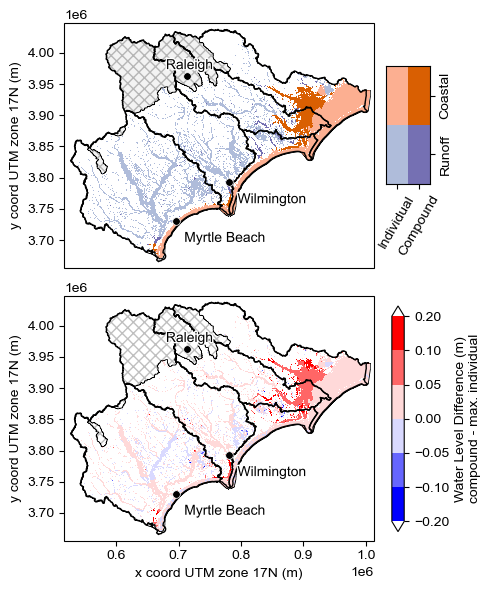

In [52]:
''' Plot 2: Peak Flood Extent Attributed '''
from matplotlib.colors import BoundaryNorm

da_diff_p = da_diff['diff in waterlevel compound minus max. single driver']
print(da_diff_p.min())
# Load CRS stuff for plotting
wkt = mod.grid['dep'].raster.crs.to_wkt()
utm_zone = mod.grid['dep'].raster.crs.to_wkt().split("UTM zone ")[1][:3]
utm = ccrs.UTM(int(utm_zone[:2]), "S" in utm_zone)
extent = np.array(basins.buffer(10000).total_bounds)[[0, 2, 1, 3]]

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6.2, 6), subplot_kw={'projection': utm}, tight_layout=True, sharex=True, sharey=False)
for i in range(len(axs)):
    if i == 1:
        # Plot difference in water level raster
        colors = ['#0000ff','#0000ff99', '#0000ff26','#ff000026','#ff000099', '#ff0000']
        levels = [-0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2]
        cmap, norm = mpl.colors.from_levels_and_colors(levels, colors)

        #cmap = plt.cm.get_cmap('bwr')
        #norm = BoundaryNorm(ranges, cmap.N)
        
        ckwargs = dict(cmap=cmap, norm=norm)
        cs = da_diff_p.plot(ax=axs[i], add_colorbar=False, **ckwargs, zorder=2)
        
        # Add colorbar
        label = 'Water Level Difference (m)\ncompound - max. individual'
        pos0 = axs[i].get_position()  # get the original position
        cax = fig.add_axes([pos0.x1 - 0.11, pos0.y0 + pos0.height * 0.15, 0.02, pos0.height * 0.7])
        cbar = fig.colorbar(cs,
                            cax=cax,
                            orientation='vertical',
                            label=label,
                            extend='both')
        axs[i].set_title('')
        axs[i].set_ylabel(f"y coord UTM zone {utm_zone} (m)")
        axs[i].yaxis.set_visible(True)
        axs[i].set_xlabel(f"x coord UTM zone {utm_zone} (m)")
        axs[i].xaxis.set_visible(True)
        axs[i].ticklabel_format(style='sci', useOffset=False)
        axs[i].set_aspect('equal')

        basins.plot(ax=axs[i], color='white', edgecolor='black',
                    linewidth=0.1, linestyle='-', zorder=0, alpha=0.25, hatch='xxx')
        mod.region.plot(ax=axs[i], color='white', edgecolor='black', linewidth=0.5, zorder=1, alpha=1)

    if i == 0:
        levels = np.arange(1, 8)
        colors = np.array([
            [252, 141, 98],
            [217, 95, 2],
            [141, 160, 203],
            [117, 112, 179],
            [102, 194, 165],
            [27, 158, 119],
        ]) / 255
        colors = np.hstack([colors, np.ones((6, 1))])
        colors[[0, 2, 4], -1] = 0.7
        cmap, norm = mpl.colors.from_levels_and_colors(levels, colors)
        
        # Plot the data
        da_c.where(da_c > 0).plot(ax=axs[i], cmap=cmap, norm=norm, add_colorbar=False, zorder=2)
        
        # Add colorbar
        pos1 = axs[i].get_position()  # get the original position
        cbar_ax = fig.add_axes([pos1.x1 - 0.13, pos1.y0 + pos1.height * 0.4, 0.07, pos1.height])
        cm = np.arange(1, 5).reshape((2, 2))
        cbar_ax.imshow(cm, cmap=cmap, norm=norm, aspect='auto')
        cbar_ax.yaxis.tick_right()
        cbar_ax.set_yticks([0, 1])
        cbar_ax.set_yticklabels(['Coastal\n', 'Runoff\n'], va='center', rotation=90, fontsize=10)
        cbar_ax.set_xticks([0, 1])
        cbar_ax.set_xticklabels(['Individual', 'Compound'], ha='center', rotation=60, fontsize=10)
        
        # Fix titles and axis labels
        axs[i].set_title('')
        axs[i].set_ylabel(f"y coord UTM zone {utm_zone} (m)")
        axs[i].yaxis.set_visible(True)
        axs[i].set_xlabel(f"x coord UTM zone {utm_zone} (m)")
        axs[i].xaxis.set_visible(False)
        axs[i].ticklabel_format(style='sci', useOffset=False)
        axs[i].set_aspect('equal')

        basins.plot(ax=axs[i], color='lightgrey', edgecolor='black', linewidth=0.1, linestyle='-', zorder=0, alpha=0.25, hatch='xxx')
        mod.region.plot(ax=axs[i], color='white', edgecolor='black', linewidth=0.5, zorder=1, alpha=1)

    # Plot background/geography layers
    basins.plot(ax=axs[i], color='none', edgecolor='black', linewidth=1, linestyle='-', zorder=3, alpha=1)
    cities.plot(ax=axs[i], marker='o', markersize=30, color="black", label='none', zorder=4, edgecolor='white', linewidth=0.5)


    # Plotting kwargs
    for label, grow in cities.iterrows():
        x, y = grow.geometry.x, grow.geometry.y
        if label == 'Raleigh':
            ann_kwargs = dict(
                xytext=(-15, 5),
                textcoords="offset points",
                zorder=4,
                path_effects=[
                    patheffects.Stroke(linewidth=2, foreground="w"),
                    patheffects.Normal(), ], )
        else:
            ann_kwargs = dict(
                xytext=(6, -15),
                textcoords="offset points",
                zorder=4,
                path_effects=[
                    patheffects.Stroke(linewidth=2, foreground="w"),
                    patheffects.Normal(), ], )
        axs[i].annotate(f'{label}', xy=(x, y), fontsize=10, **ann_kwargs)

    # Setup figure extents
    minx, miny, maxx, maxy = basins.total_bounds
    axs[i].set_xlim(minx, maxx)
    axs[i].set_ylim(miny, maxy)
    axs[i].set_extent(extent, crs=utm)

plt.subplots_adjust(wspace=0, hspace=0)
plt.margins(x=0, y=0)
plt.savefig(os.path.join(os.getcwd(), 'peak_flooding_process_attribution_Flor.png'), dpi=225, bbox_inches="tight")
#plt.close()
print(os.getcwd())

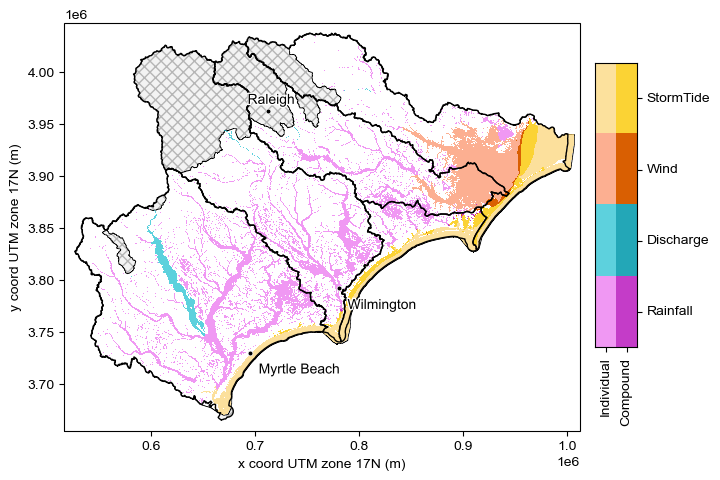

In [9]:
''' Plot 3: Peak Flood Extent Attributed to Drivers'''

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5), subplot_kw={'projection': utm}, tight_layout=True)

levels = np.arange(1, 12)
# https://htmlcolorcodes.com/
colors = np.array([
    [251, 212, 115],  # Yellow
    [251, 211, 52],
    [252, 141, 98],  # Orange
    [217, 95, 2],
    # [102, 194, 165],  # Green
    # [27, 158, 119],
    [23, 190, 207],  # Blue
    [35, 167, 183],
    [234, 108, 238],  # Pink
    [196, 60, 200],
    # [71, 108, 236],  # Dark Blue
    # [28, 56, 149],
    [141, 160, 203],  # Purple
    [117, 112, 179],
]) / 255
colors = np.hstack([colors, np.ones((10, 1))])
colors[[0, 2, 4, 6, 8], -1] = 0.7
cmap, norm = mpl.colors.from_levels_and_colors(levels, colors)

# Plot the data
da_c_drivers.where(da_c > 0).plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False, zorder=2)

# Add colorbar
pos1 = ax.get_position()  # get the original position
cbar_ax = fig.add_axes([pos1.x1 + 0.1, pos1.y0 + pos1.height * 0.2, 0.07, pos1.height * 0.8])
cm = np.arange(1, 9).reshape((4, 2))
cbar_ax.imshow(cm, cmap=cmap, norm=norm, aspect='auto')
cbar_ax.yaxis.tick_right()
cbar_ax.set_yticks([0, 1, 2, 3])
cbar_ax.set_yticklabels(['StormTide', 'Wind', 'Discharge', 'Rainfall'], va='center', rotation=0)
cbar_ax.set_xticks([0, 1])
cbar_ax.set_xticklabels(['Individual', 'Compound'], ha='center', rotation=90)

# Fix titles and axis labels
ax.set_title('')
ax.set_ylabel(f"y coord UTM zone {utm_zone} (m)")
ax.yaxis.set_visible(True)
ax.set_xlabel(f"x coord UTM zone {utm_zone} (m)")
ax.xaxis.set_visible(True)
ax.ticklabel_format(style='sci', useOffset=False)
ax.set_aspect('equal')

# Plot background/geography layers
basins.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.1, linestyle='-', zorder=0, alpha=0.25, hatch='xxx')
mod.region.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5, zorder=1, alpha=1)
basins.plot(ax=ax, color='none', edgecolor='black', linewidth=1, linestyle='-', zorder=3, alpha=1)
cities.plot(ax=ax, marker='o', markersize=12, color="black", label='none', zorder=4, edgecolor='white', linewidth=0.5)

# Plotting kwargs
for label, grow in cities.iterrows():
    x, y = grow.geometry.x, grow.geometry.y
    if label == 'Raleigh':
        ann_kwargs = dict(
            xytext=(-15, 5),
            textcoords="offset points",
            zorder=4,
            path_effects=[
                patheffects.Stroke(linewidth=2, foreground="w"),
                patheffects.Normal(), ], )
    else:
        ann_kwargs = dict(
            xytext=(6, -15),
            textcoords="offset points",
            zorder=4,
            path_effects=[
                patheffects.Stroke(linewidth=2, foreground="w"),
                patheffects.Normal(), ], )
    ax.annotate(f'{label}', xy=(x, y), fontsize=10, **ann_kwargs)

# Setup figure extents
minx, miny, maxx, maxy = basins.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_extent(extent, crs=utm)

plt.subplots_adjust(wspace=0, hspace=0)
plt.margins(x=0, y=0)
plt.savefig(os.path.join(out_dir, 'compound_analysis_sfincs_byforcing.png'), dpi=225, bbox_inches="tight")
#plt.close()